# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


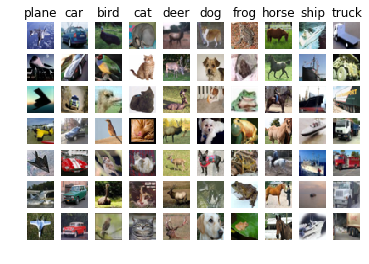

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


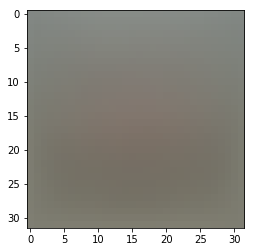

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.131331


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -45.307421 analytic: -45.307421, relative error: 9.482780e-12
numerical: -2.217311 analytic: -2.196016, relative error: 4.825156e-03
numerical: -7.111886 analytic: -7.111886, relative error: 9.455219e-11
numerical: 13.504534 analytic: 13.469466, relative error: 1.300062e-03
numerical: 14.718389 analytic: 14.718389, relative error: 1.163901e-11
numerical: 35.917725 analytic: 35.917725, relative error: 7.607760e-12
numerical: -6.478196 analytic: -6.478196, relative error: 1.244242e-11
numerical: -5.413147 analytic: -5.359497, relative error: 4.980203e-03
numerical: 9.391927 analytic: 9.391927, relative error: 5.455720e-11
numerical: -3.567260 analytic: -3.567260, relative error: 3.179556e-11
numerical: -62.303097 analytic: -62.303097, relative error: 9.387707e-13
numerical: -7.639108 analytic: -7.639108, relative error: 2.104322e-11
numerical: 30.353096 analytic: 30.380138, relative error: 4.452655e-04
numerical: 15.209269 analytic: 15.213828, relative error: 1.498263e-04
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

1. A max() or min() function
2. I think by "is it a reason for concern?" the writer of this question was trying to ask "Did we calculate the gradient wrong?  Is our gradient wrong because the numerical gradient is not equal to the analytic gradient?"  The answer is no.  A piecewise-function can be hard to differentiate-across at boundaries, but it doesn't matter as long as the classifier "learns" the right thing and ends up making good predictions at the end of the day.  And over many training examples, our SVM will learn what it needs to learn; how to classify different images into different classes
3. An example of "a simple example in one dimension where a gradient check could fail" is f=max(0,x).  Around 0, if the step "h" used to calculate the numerical gradient is bigger than the current value of x (ie. x=-0.1 and h=0.2), we'll get a different answer; analytical gradient f'(-0.1) == 0, but (max(0, 0.1)- max(0, -0.1)) / 0.2 == 0.5.  
4. I don't think it would, except maybe in specific cases.  The weights would just gather around values that predicted the right answers with higher confidence over the baseline

In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_naive # on Sat Jun 22 16:22:23 UTC 2019,  nxBendich added this line
#why?  it "refreshes" the naive import
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.131331e+00 computed in 0.157127s
Vectorized loss: 9.131331e+00 computed in 0.011771s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

from cs231n.classifiers.linear_svm import svm_loss_naive

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.157862s
Vectorized loss and gradient: computed in 0.010745s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.010340
iteration 100 / 1500: loss 286.494615
iteration 200 / 1500: loss 108.075861
iteration 300 / 1500: loss 42.761744
iteration 400 / 1500: loss 18.696754
iteration 500 / 1500: loss 10.291154
iteration 600 / 1500: loss 7.213358
iteration 700 / 1500: loss 5.384925
iteration 800 / 1500: loss 5.820231
iteration 900 / 1500: loss 5.397771
iteration 1000 / 1500: loss 4.969580
iteration 1100 / 1500: loss 5.075741
iteration 1200 / 1500: loss 5.617465
iteration 1300 / 1500: loss 5.565645
iteration 1400 / 1500: loss 4.961563
That took 6.374569s


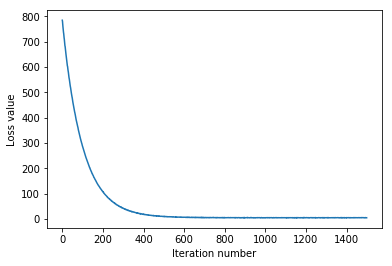

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368204
validation accuracy: 0.375000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Me (Nathan):   Mwahaha! I already have 0.38 on the validation set!
# Me (also Nathan):  Yeah, but also; fiddling with hyperparameters is often a total waste of time and sometimes isn't worth doing.
#                   As long as you have your initial model correct and you didn't make any incorrect assumptions about the initial problem, you'll be fine.
#                   The "best" SVM I got from my best run here (0.398 on the validation dataset) got a shitty 0.366000 on the test set.



#Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# lr 
learning_rates = [5e-8]  # np.linspace(1e-8, 1.5e-7, 20) #1e-5, 4) #5e-5, 10)# [1e-7, 5e-5]
#reg should probably be lower than 2.5e4
regularization_strengths = [1.5e4]  # np.linspace(1e4, 5e4, 20) #[2.5e4]  #[2.5e4, 5e4]

N_iters = np.linspace(1000,2500,20)    # if we were doing this for real, I'd want to double-triple check every possible "hyperparameter"

for lr in learning_rates:
    for reg in regularization_strengths:
        for N in N_iters:
            # Initialize:
            svm=LinearSVM()

            # Train:
            _ = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters= 1500, #400,   # 400 gave us ~ 0.35 acc;  0.35 is definitely underfitting??
                            verbose=False) #True)
            # num_iters is also a hyperparameter???

            # Predict:
            y_train_pred = svm.predict(X_train)
            train_acc    = np.mean(y_train_pred == y_train)
            y_val_pred   = svm.predict(X_val)
            val_acc      = np.mean(y_val_pred == y_val)

            # Save best:
            if val_acc > best_val:
                best_val= val_acc
                best_svm = svm

            # Save all:
            results[(lr, reg)] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 1.500000e+04 train accuracy: 0.374653 val accuracy: 0.385000
best validation accuracy achieved during cross-validation: 0.391000


In [19]:
results

{(5e-08, 15000.0): (0.37465306122448977, 0.385)}

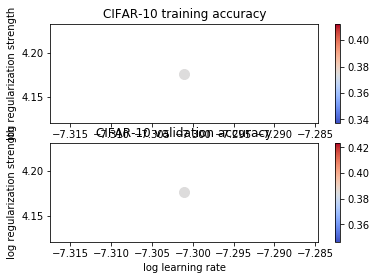

In [15]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.368000


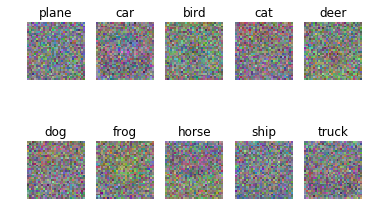

In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 
They're pretty ugly.  It's hard to be 100% certain why they look this way.  It's now much clearer to me why you need a deep NN/CNN to classify images; this simple template doesn't even come close to explaining how an animal looks.  For one, color has *almost* nothing to do with what makes an object a member of its class.  Any kid can imagine a blue dog, even though there aren't *really* blue dogs wandering around the world (at least, to the best of *my* knowledge; we haven't been to exoplanets yet).

To the question, you can see a few things;

1. Cars: the template looks like a red car facing "towards" the camera.  (windshield towards us)  Maybe the cars in the CIFAR-10 dataset are a purplish reddish color (maybe some black ones, some blue ones, and some bright red; the black might be making it look purple), and they're mostly facing "forward" where their windshield is facing the viewer (ie. I don't think we see the side doors or the trunk in most of them)  After looking at some actual CIFAR-10 images [here](https://www.cs.toronto.edu/~kriz/cifar.html), I'm not sure where the purplish reddish color comes from.  There don't seem to be many blue cars in CIFAR-10 from the subsampling on that webpage

2. Frog: the frogs are mostly green, though there I see many brown ones in the subsample of CIFAR-10 found [here](https://www.cs.toronto.edu/~kriz/cifar.html).  Maybe they have red eyes?  (my interpretation of the yellow blob near top of img frame)
3. Horse: There are horses facing "both" directions (left and right), but prob not many facing directly towards or directly away from the camera.
4. Deer: mostly in green backgrounds (outside, in meadows, etc.).  sky looks blue
5. Ship: blue background, maybe grey hull?  Or half the ships in CIFAR-10 are black and the other half are white
6. Cat: strangely purple background where the "ground" should be
7. Plane: blue skies
8. Dog: brown blob near the top of the 32x32 frame.  Is this blob the dog's body?  After looking at the actual CIFAR-10 images, it's clear that dog color is pretty varied.  At least, it is between brown, black and white
9. Truck:  Sky in the top section.  Maybe facing forward?  Hard to tell.  After looking at the actual CIFAR-10 images, I realized trucks are also (like birds) extremely varied in color.  
10. Bird: green/cyan blobs where the wings are.  After looking at actual CIFAR-10 images, I realized "bird" is an extremely general "class" that includes ostriches, chickens, and other large birds, as well as the usual tiny birds (ie. sparrows, robins) I mostly think of when I hear the word "bird."  I'm still not sure why there are those bright gren blobs off-center.  Maybe because there's sometimes bright whitish-blue sky in the background and other times green in the background

#### Note: all these explanations became a lot more sensible and less "guesswork-y" after I actually pulled out the CIFAR-10 images and looked at them


<h1><center>Just old debugging cells below</center></h1>

# Debugging SGD
iteration 0 / 1500: loss 806.

iteration 100 / 1500: loss 2593.153023

iteration 200 / 1500: loss 6726.092095

iteration 300 / 1500: loss 17315.978126

iteration 400 / 1500: loss 44877.030617

iteration 500 / 1500: loss 118040.231553

iteration 600 / 1500: loss 313892.866226

iteration 700 / 1500: loss 841338.695750

iteration 800 / 1500: loss 2265014.362121

iteration 900 / 1500: loss 6115181.221590

iteration 1000 / 1500: loss 16538531.130522

iteration 1100 / 1500: loss 44774309.658595

iteration 1200 / 1500: loss 121293514.309824

iteration 1300 / 1500: loss 328698296.056450

iteration 1400 / 1500: loss 890957354.332099

That took 6.275195s


# More debugging
print("grad_naive :      \n", grad_naive     [:3, :3])
print("grad_vectorized : \n", grad_vectorized[:3, :3])

print("grad_naive.shape:       \n", grad_naive.shape)
print("grad_vectorized.shape : \n", grad_vectorized.shape)

# More debugging
print("W_debug :         \n", W_debug        [:3, :3])
print("grad_naive :      \n", grad_naive     [:3, :3])
print("grad_vectorized : \n", grad_vectorized[:3, :3])

print("ons.shape:        \n", ons.shape)
print("margins.shape:    \n", margins.shape)
print("np.count_nonzero(ons):        \n", np.count_nonzero(ons))
print("np.count_nonzero(margins):     \n", np.count_nonzero(margins))


print("grad_naive.shape:       \n", grad_naive.shape)
print("grad_vectorized.shape : \n", grad_vectorized.shape)

In [18]:
# JUST debugging ONE of the terms in the svm_loss_vectorized() func.

# I think we don't need initial weights W to calculate gradients;
#   We just need the var "ons" to have the same values I computed on the board 


#X=X_dev
#y=y_dev
#reg=0.000005 # from the cell starting    "# Next implement the function svm_loss_vectorized; for now only compute the loss;"

# Vectorized;   NOT naive (NOT for loops)
# Vectorized;   NOT naive (NOT for loops)
# Vectorized;   NOT naive (NOT for loops)
# Vectorized;   NOT naive (NOT for loops)
# Vectorized;   NOT naive (NOT for loops)


X         = np.array([[1],[5],[-4]], dtype="int64")
ons       = np.array(
   [[1,0],
    [0,1],
    [1,1]],dtype='int64')
dW        = np.zeros((1,2)) # initialize the gradient as zero

n_classes = dW.shape[1]
n_train   = X.shape[0]
scores    = X.dot(W) # scores.shape==(N, 10)

# corrects_scores.shape == (n_train,)
corrects_scores = scores[range(n_train), y]

# reshape "corrects" to (n_train, n_classes)      so we can subtract the loss in "margins" in a vectorized way
corrects_scores = np.repeat(
  corrects_scores.reshape( n_train, 1 ),
  n_classes,
  axis=1)

margins = scores - corrects_scores + 1 # note delta = 1        TODO:  ***problem with j == correct_class***
margins[np.less(margins, 0)] = 0

# We added too many "1"s when we failed to account for the "if j==y[i]: continue" from the naive implmentation  "svm_loss_naive(W, X, y, reg)"
# We want the loss to be an average instead so we divide by num_train.
loss    = \
  (np.sum(margins)   - n_train)\
  / n_train

# Add regularization to the loss.
loss  += reg * np.sum(W * W)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#############################################################################
# TODO:                                                                     #
# Implement a vectorized version of the gradient for the structured SVM     #
# loss, storing the result in dW.                                           #
#                                                                           #
# Hint: Instead of computing the gradient from scratch, it may be easier    #
# to reuse some of the intermediate values that you used to compute the     #
# loss.                                                                     #
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#######################################
# in          "def svm_loss_vectorized(W, X, y, reg):"
ons=np.greater(margins, 0).astype('int64') # 'int64' b/c zeros and ones are more intuitive for matrix multiplication than bools
# The below term is the same term as
#   "dW[:,j] -= X[i]"
#   (from the "svm_loss_naive" version of this function (the "naive" version has a for-loop))
dW -= ((ons.T).dot(X)).T


ValueError: shapes (3,1) and (3073,10) not aligned: 1 (dim 1) != 3073 (dim 0)

In [ ]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
#############################################################################
    # TODO: finish this func
#############################################################################
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # TODO: comments
    # TODO: comments    (brief explanation)
    # TODO: comments
    n_classes = W.shape[1]
    n_train = X.shape[0]
    scores=X.dot(W) # scores.shape==(N, 10)
    
    # corrects_scores.shape == (n_train,)
    corrects_scores = scores[range(n_train), y]
    
    # reshape "corrects" to (n_train, n_classes)      so we can subtract the loss in "margins" in a vectorized way
    corrects_scores = np.repeat(
      corrects_scores.reshape( n_train, 1 ),
      n_classes,
      axis=1)
      
    margins = scores - corrects_scores + 1 # note delta = 1        TODO:  ***problem with j == correct_class***
    margins[np.less(margins, 0)] = 0

    # We added too many "1"s when we failed to account for the "if j==y[i]: continue" from the naive implmentation  "svm_loss_naive(W, X, y, reg)"
    # We want the loss to be an average instead so we divide by num_train.
    loss    = \
      (np.sum(margins)   - n_train)\
      / n_train
      
    # Add regularization to the loss.
    loss  += reg * np.sum(W * W)
    
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    #######################################
    # in          "def svm_loss_vectorized(W, X, y, reg):"
    ons=np.greater(margins, 0).astype('int64') # 'int64' b/c zeros and ones are more intuitive for matrix multiplication than bools
    # The below term is the same term as
    #   "dW[:,j] -= X[i]"
    #   (from the "svm_loss_naive" version of this function (the "naive" version has a for-loop))
    dW -= ((ons.T).dot(X)).T
    #######################################


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


print("y_dev.shape:", y_dev.shape)

In [ ]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
    
    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train): 
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin
    
                # Take gradient:
                # X[i] is the gradient  (partial deriv w.r.t. W[:,y[i]])
                #dW[:,y[i]]  +=  X[i]  # TODO: uncomment!
                # X[i] is the gradient  (partial deriv w.r.t. W[:,   j])
                dW[:,j]     -=  X[i]
    
    #   Shouldn't dW be /= num_train   right here?        But my answer was validated by the auto-check.   lolololol ROFLMAO.
    # dW  /=  num_train

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss  /=  num_train
    
    # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    
    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    
    #############################################################################
    # Partial derivative of d(reg_term) / dW   == 2*lambda*W

    # It's easier to see if we do it elementwise; the regularization term   is reg*(element**2).
    #   So    d(term) / d(element)  == 2*reg*element
    #dW += 2*reg*W   # TODO: uncomennt!
    #############################################################################


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


In [ ]:

'''
  Documenting 4 debugging's sake:
  
Naive loss and gradient: computed in 0.161371s
Vectorized loss and gradient: computed in 0.007249s
difference: 0.000000
'''


In [ ]:
#ons2.shape  ==(500, 10)
#print(y.shape) # (500,)
print(y[0]) # 4
print("ons2[ 0,y[0]]: ", ons2[ 0,y[0]])
print("ons2[ 0,y[0]].shape: ", ons2[ 0,y[0]].shape)
ons2[ range(y.shape[0]), y].shape

# was just  debugging
print("loss: ",loss)
dW = np.zeros(W.shape)
##### where loss is added
nonzero=np.nonzero(margins)

Is=nonzero[0] # "Is" because 'is' is a python keyword
Js=nonzero[1] # "Js" because I capitalized 'Is'
print("Is.shape : ", Is.shape)  # Is.shape==(4917,)
print("Js.shape : ", Js.shape)  # Js.shape==(4917,)
print("\n"*3)

print("margins.shape: ", margins.shape)
print("corrects_scores.shape: ", corrects_scores.shape)
print("scores.shape: ", scores.shape)
print("\n"*3)

print("dW.shape : ", dW.shape)
print("X[Is].shape : ", X[Is].shape)
print("y[Is].shape : ", y[Is].shape)
dW[:,y[Is]]+=X[Is]
dW[:,Js]   -= X[Is]

print("nonzero: ", nonzero)
print("len(nonzero): ", len(nonzero))
print("nonzero.shape: ", nonzero.shape)

# Debugging
ons=margins==0

print("ons.shape: \n", ons.shape)
#####print("ons: \n", ons)
'''
ons: 
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False  True ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
'''



#def svm_loss_vectorized(W, X, y, reg):
"""
Structured SVM loss function, vectorized implementation.

Inputs and outputs are the same as svm_loss_naive.
"""
X=X_dev
y=y_dev
reg=0.000005
loss = 0.0
dW = np.zeros(W.shape) # initialize the gradient as zero

#############################################################################
# TODO:                                                                     #
# Implement a vectorized version of the structured SVM loss, storing the    #
# result in loss.                                                           #
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: comments
# TODO: comments    (brief explanation)
# TODO: comments

# if you have questions, please see the function "svm_loss_naive()" :   most of the code implemented there is the same as the code implemented here, although with 2 for loops instead of vectorization
n_classes = W.shape[1]
n_train = X.shape[0]
scores=X.dot(W) # scores.shape==(N, 10)

# corrects_scores.shape == (n_train,)
corrects_scores = scores[range(n_train), y]

# reshape "corrects" to (n_train, n_classes)      so we can subtract the loss in "margins" in a vectorized way
corrects_scores = np.repeat(
  corrects_scores.reshape( n_train, 1 ),
  n_classes,
  axis=1)

margins = scores - corrects_scores + 1 # note delta = 1        TODO:  ***problem with j == correct_class***
# only changes loss and grads func if margin > 0 (see svm_loss_naive)
margins[np.less(margins, 0)] = 0

# We added too many "1"s when we failed to account for the "if j==y[i]: continue" from the naive implmentation  "svm_loss_naive(W, X, y, reg)"
margins[range(margins.shape[0]),y]=0
# We want the loss to be an average instead so we divide by num_train.
loss    =  np.sum(margins)    / n_train

# Add regularization to the loss.
loss  += reg * np.sum(W * W)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#############################################################################
# TODO:                                                                     #
# Implement a vectorized version of the gradient for the structured SVM     #
# loss, storing the result in dW.                                           #
#                                                                           #
# Hint: Instead of computing the gradient from scratch, it may be easier    #
# to reuse some of the intermediate values that you used to compute the     #
# loss.                                                                     #
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#######################################
# in          "def svm_loss_vectorized(W, X, y, reg):"
ons=np.greater(margins, 0).astype('int64') # 'int64' b/c zeros and ones are more intuitive for matrix multiplication than bools
# The below term is the same term as
#   "dW[:,j] -= X[i]"
#   (from the "svm_loss_naive" version of this function (the "naive" version has a for-loop))
dW -= ((ons.T).dot(X)).T

ons2=np.zeros(ons.shape)
ACROSS=1
#ons2[ range(y.shape[0]): y]     = np.sum(ons, axis=ACROSS) # TODO TODO TODO: uncomment this line.
#dW+= (    (ons2.T).dot(X)    ).T                           # TODO TODO TODO: uncomment this line.
#######################################
# Loss due to regularization:
#dW += 2*reg*W   # TODO: uncomennt!
#######################################

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#return loss, dW


In [ ]:
# Results for my records:


# I used validation to figured out the best learning rate 1st.
#   2. then reg
#   3. then N_iters

#Trial:     # iterations:
# i    n



# 1   1600 iters
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370531 val accuracy: 0.389000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359061 val accuracy: 0.355000
lr 1.000000e-05 reg 2.500000e+04 train accuracy: 0.156633 val accuracy: 0.161000
lr 1.000000e-05 reg 5.000000e+04 train accuracy: 0.177388 val accuracy: 0.180000    ??? why did upping the red do **better** here?
best validation accuracy achieved during cross-validation:
    0.389000

    
    
    
# 2:   900 iters
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.368061 val accuracy: 0.368000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.356959 val accuracy: 0.356000

        
        
        
# 3   1500 iters
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.361816 val accuracy: 0.377000
lr 1.200000e-06 reg 2.500000e+04 train accuracy: 0.310857 val accuracy: 0.314000
lr 2.300000e-06 reg 2.500000e+04 train accuracy: 0.204592 val accuracy: 0.206000
lr 3.400000e-06 reg 2.500000e+04 train accuracy: 0.204286 val accuracy: 0.209000
lr 4.500000e-06 reg 2.500000e+04 train accuracy: 0.183755 val accuracy: 0.185000
lr 5.600000e-06 reg 2.500000e+04 train accuracy: 0.194000 val accuracy: 0.214000
lr 6.700000e-06 reg 2.500000e+04 train accuracy: 0.172857 val accuracy: 0.169000
lr 7.800000e-06 reg 2.500000e+04 train accuracy: 0.177980 val accuracy: 0.174000
lr 8.900000e-06 reg 2.500000e+04 train accuracy: 0.158408 val accuracy: 0.161000
lr 1.000000e-05 reg 2.500000e+04 train accuracy: 0.165918 val accuracy: 0.177000
best validation accuracy achieved during cross-validation:
    0.377000

    
    
    
# 4   1,500 iters
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.373429 val accuracy: 0.380000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.365163 val accuracy: 0.369000
        
lr 1.500000e-07 reg 2.500000e+04 train accuracy: 0.370265 val accuracy: 0.375000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.360755 val accuracy: 0.364000
lr 2.500000e-07 reg 2.500000e+04 train accuracy: 0.358531 val accuracy: 0.363000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.344490 val accuracy: 0.360000
lr 3.500000e-07 reg 2.500000e+04 train accuracy: 0.357816 val accuracy: 0.364000
lr 4.000000e-07 reg 2.500000e+04 train accuracy: 0.334347 val accuracy: 0.353000
lr 4.500000e-07 reg 2.500000e+04 train accuracy: 0.329755 val accuracy: 0.358000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.335245 val accuracy: 0.330000
lr 5.500000e-07 reg 2.500000e+04 train accuracy: 0.330735 val accuracy: 0.322000
lr 6.000000e-07 reg 2.500000e+04 train accuracy: 0.315143 val accuracy: 0.331000
lr 6.500000e-07 reg 2.500000e+04 train accuracy: 0.335347 val accuracy: 0.353000
lr 7.000000e-07 reg 2.500000e+04 train accuracy: 0.325449 val accuracy: 0.327000
lr 7.500000e-07 reg 2.500000e+04 train accuracy: 0.310082 val accuracy: 0.326000
lr 8.000000e-07 reg 2.500000e+04 train accuracy: 0.282163 val accuracy: 0.297000
lr 8.500000e-07 reg 2.500000e+04 train accuracy: 0.289755 val accuracy: 0.301000
lr 9.000000e-07 reg 2.500000e+04 train accuracy: 0.294510 val accuracy: 0.298000
lr 9.500000e-07 reg 2.500000e+04 train accuracy: 0.279327 val accuracy: 0.301000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.287245 val accuracy: 0.306000
best validation accuracy achieved during cross-validation: 
    0.380000

    
    
# 5:  1,500 iters
lr 1.000000e-08 reg 2.500000e+04 BAD train accuracy: 0.244816 val accuracy: 0.233000 BAD
lr 1.736842e-08 reg 2.500000e+04 train accuracy: 0.314939 val accuracy: 0.309000
lr 2.473684e-08 reg 2.500000e+04 train accuracy: 0.349429 val accuracy: 0.368000
lr 3.210526e-08 reg 2.500000e+04 train accuracy: 0.367796 val accuracy: 0.389000
lr 3.947368e-08 reg 2.500000e+04 train accuracy: 0.371694 val accuracy: 0.380000
lr 4.684211e-08 reg 2.500000e+04 train accuracy: 0.373429 val accuracy: 0.398000 GREAT!  But is this some magic bullsh!t?  It seems like quite a leap up from the prev number
lr 5.421053e-08 reg 2.500000e+04 train accuracy: 0.373878 val accuracy: 0.379000
lr 6.157895e-08 reg 2.500000e+04 train accuracy: 0.369694 val accuracy: 0.381000
lr 6.894737e-08 reg 2.500000e+04 train accuracy: 0.371020 val accuracy: 0.375000
lr 7.631579e-08 reg 2.500000e+04 train accuracy: 0.367918 val accuracy: 0.368000
lr 8.368421e-08 reg 2.500000e+04 train accuracy: 0.370306 val accuracy: 0.379000
lr 9.105263e-08 reg 2.500000e+04 train accuracy: 0.371857 val accuracy: 0.387000
lr 9.842105e-08 reg 2.500000e+04 train accuracy: 0.375673 val accuracy: 0.370000
lr 1.057895e-07 reg 2.500000e+04 train accuracy: 0.373571 val accuracy: 0.385000
lr 1.131579e-07 reg 2.500000e+04 train accuracy: 0.371816 val accuracy: 0.377000
lr 1.205263e-07 reg 2.500000e+04 train accuracy: 0.373796 val accuracy: 0.377000
lr 1.278947e-07 reg 2.500000e+04 train accuracy: 0.357041 val accuracy: 0.370000
lr 1.352632e-07 reg 2.500000e+04 train accuracy: 0.368408 val accuracy: 0.376000
lr 1.426316e-07 reg 2.500000e+04 train accuracy: 0.369469 val accuracy: 0.383000
lr 1.500000e-07 reg 2.500000e+04 train accuracy: 0.367061 val accuracy: 0.376000
best validation accuracy achieved during cross-validation: 
    0.398000
    0.389000

# 5. Results on Test data:
It was less impressive.  I **think** it was like 0.36?
linear SVM on raw pixels final test set accuracy: 0.3...?????

# 6:  1,500 iters
#   This time I trained across multiple **regularization** values lambda.  seems like the lower values (~ 1e4 instead of 5e4) do better, on avg
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.378878 val accuracy: 0.391000
lr 1.000000e-07 reg 1.210526e+04 train accuracy: 0.385347 val accuracy: 0.392000
lr 1.000000e-07 reg 1.421053e+04 train accuracy: 0.377816 val accuracy: 0.383000
lr 1.000000e-07 reg 1.631579e+04 train accuracy: 0.380408 val accuracy: 0.387000
lr 1.000000e-07 reg 1.842105e+04 train accuracy: 0.374531 val accuracy: 0.384000
lr 1.000000e-07 reg 2.052632e+04 train accuracy: 0.371184 val accuracy: 0.390000
lr 1.000000e-07 reg 2.263158e+04 train accuracy: 0.377224 val accuracy: 0.378000
lr 1.000000e-07 reg 2.473684e+04 train accuracy: 0.363041 val accuracy: 0.373000
lr 1.000000e-07 reg 2.684211e+04 train accuracy: 0.365796 val accuracy: 0.376000
lr 1.000000e-07 reg 2.894737e+04 train accuracy: 0.364796 val accuracy: 0.380000
lr 1.000000e-07 reg 3.105263e+04 train accuracy: 0.365408 val accuracy: 0.367000
lr 1.000000e-07 reg 3.315789e+04 train accuracy: 0.361980 val accuracy: 0.372000
lr 1.000000e-07 reg 3.526316e+04 train accuracy: 0.364286 val accuracy: 0.366000
lr 1.000000e-07 reg 3.736842e+04 train accuracy: 0.357041 val accuracy: 0.366000
lr 1.000000e-07 reg 3.947368e+04 train accuracy: 0.356429 val accuracy: 0.366000
lr 1.000000e-07 reg 4.157895e+04 train accuracy: 0.357163 val accuracy: 0.357000
lr 1.000000e-07 reg 4.368421e+04 train accuracy: 0.358347 val accuracy: 0.369000
lr 1.000000e-07 reg 4.578947e+04 train accuracy: 0.358796 val accuracy: 0.366000
lr 1.000000e-07 reg 4.789474e+04 train accuracy: 0.362878 val accuracy: 0.361000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359061 val accuracy: 0.358000
best validation accuracy achieved during cross-validation: 0.392000

# 6. Results on Test data:
linear SVM on raw pixels final test set accuracy: 0.378000



# "debugging svm_loss_vectorized() into existence:"

W,X,y,reg = W, X_dev, y_dev, 0.000005

#def svm_loss_vectorized(W, X, y, reg):
"""
Structured SVM loss function, vectorized implementation.

Inputs and outputs are the same as svm_loss_naive.
"""
loss = 0.0
dW = np.zeros(W.shape) # initialize the gradient as zero

#############################################################################
# TODO:                                                                     #
# Implement a vectorized version of the structured SVM loss, storing the    #
# result in loss.                                                           #
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: comments
# TODO: comments
# TODO: comments    (brief explanation)
# TODO: comments
# TODO: comments
n_classes = W.shape[1]
n_train = X.shape[0]
scores=X.dot(W) # scores.shape==(N, 10)

# corrects_scores.shape == (n_train,)
corrects_scores = scores[range(n_train), y]

# reshape "corrects" to (n_train, n_classes)      so we can subtract the loss in "margins" in a vectorized way
corrects_scores = np.repeat(
  corrects_scores.reshape( n_train, 1 ),
  n_classes,
  axis=1)

margins = scores - corrects_scores + 1 # note delta = 1        TODO:  ***problem with j == correct_class***
margins[np.less(margins, 0)] = 0

# We added too many "1"s when we failed to account for the "if j==y[i]: continue" from the naive implmentation  "svm_loss_naive(W, X, y, reg)"
# We want the loss to be an average instead so we divide by num_train.
loss    = \
  (np.sum(margins)   - n_train)\
  / n_train

# Add regularization to the loss.
loss  += reg * np.sum(W * W)


In [ ]:
from pprint import pprint as p
p(dir(best_svm))
# I wanted to know which starting attributes it had.... (ie. lr, reg, etc.)

# training   accuracy: 0.370204
# validation accuracy: 0.381000

# KNN maxed out at (roughly) 0.3000 for 5-NN:
